In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import json
import os
from pprint import pprint
import sys

import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyedflib
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from scipy import signal

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import constants, pkeys, viz
from sleeprnn.helpers import reader, plotter, printer, misc
from sleeprnn.data import utils

%matplotlib inline
viz.notebook_full_width()

In [2]:
dataset = reader.load_dataset(constants.MASS_SS_NAME)
signals, _ = dataset.get_data(pages_subset=constants.N2_RECORD, augmented_page=False, normalize_clip=True)

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042


In [3]:
scaler = StandardScaler()
# projector = PCA(n_components=2)
projector = KernelPCA(n_components=2, kernel="rbf", gamma=0.1)

In [4]:
# Frequency bands to be considered
bands = [
    (1, 4),
    (4, 8),
    (8, 12),
    (12, 15),
    (15, 20)
]

# For each subject compute FFT
concatenated_power = []
per_subject_power = {}
for k, subject_id in enumerate(dataset.get_ids()):
    pages_power = []
    for single_page in signals[k]:
        
        this_power, this_freq = utils.power_spectrum(single_page, dataset.fs)
        
        # this_freq, t, Zxx = signal.stft(single_page, dataset.fs, nperseg=400)
        # this_power = np.abs(Zxx).mean(axis=1)
        
        bands_power = []
        for band in bands:
            useful_power = this_power[(band[0] <= this_freq) & (this_freq <= band[1])]
            single_band_power = np.log(useful_power.mean())
            bands_power.append(single_band_power)
        pages_power.append(bands_power)
    pages_power = np.stack(pages_power, axis=0)
    per_subject_power[subject_id] = pages_power.copy()
    concatenated_power.append(pages_power)
concatenated_power = np.concatenate(concatenated_power, axis=0)

# Normalize
scaler.fit(concatenated_power)
norm_concat_power = scaler.transform(concatenated_power)
norm_subject_power = {}
for subject_id in dataset.get_ids():
    norm_subject_power[subject_id] = scaler.transform(per_subject_power[subject_id])

# Project data
projector.fit(norm_concat_power)
projected_concat_power = projector.transform(norm_concat_power)

# Explained variance
# print(projector.explained_variance_ratio_.cumsum())

# Search location of each subject in plot
subject_locations = {}
subject_cov_locations = {}
for subject_id in norm_subject_power.keys():
    pages_power = norm_subject_power[subject_id]
    pages_projected = projector.transform(pages_power)
    mean = np.mean(pages_projected, axis=0)
    cov = np.cov(pages_projected, rowvar=0)
    subject_locations[subject_id] = mean
    subject_cov_locations[subject_id] = cov

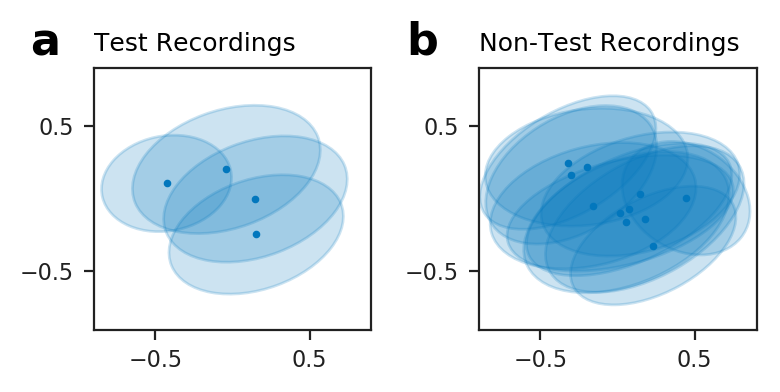

In [34]:
# Projection of subjects
fig, axes = plt.subplots(1, 2, figsize=(4, 2), dpi=200)
max_value = 0.9
test_subjects = dataset.test_ids.copy()

for subject_id in subject_locations.keys():
    position = subject_locations[subject_id]
    covariances = subject_cov_locations[subject_id]
    if subject_id in test_subjects:
        color = viz.PALETTE['blue']
        zorder = 20
        ax_ell = axes[0]
    else:
        color = viz.PALETTE['blue']
        zorder = 10
        ax_ell = axes[1]
    ax_ell.scatter(position[0], position[1], c=color, s=3, zorder=zorder)#, 'o', color=color, markersize=2, zorder=zorder)
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2. * 1.96 * np.sqrt(v)
    ell = mpl.patches.Ellipse(position, v[0], v[1], 180 + angle, color=color)
    ell.set_clip_box(ax_ell.bbox)
    ell.set_alpha(0.2)
    ax_ell.add_artist(ell)
[ax.set_xlim([-max_value, max_value]) for ax in axes]
[ax.set_ylim([-max_value, max_value]) for ax in axes]
[ax.set_xticks([-0.5, 0.5]) for ax in axes]
[ax.set_yticks([-0.5, 0.5]) for ax in axes]
[ax.tick_params(labelsize=viz.FONTSIZE_GENERAL) for ax in axes]
[plotter.set_axis_color(ax, viz.GREY_COLORS[9]) for ax in axes]
#axes[0].set_title('Mean Location', fontsize=viz.FONTSIZE_GENERAL, loc='left')
axes[1].set_title('Non-Test Recordings', fontsize=viz.FONTSIZE_TITLE, loc='left')
axes[0].set_title('Test Recordings', fontsize=viz.FONTSIZE_TITLE, loc='left')
plt.tight_layout()

plt.text(
    x=0.05, y=0.87, fontsize=16, 
    s=r"$\bf{a}$", 
    ha="left", transform=fig.transFigure)#, color=general_color)
plt.text(
    x=0.52, y=0.87, fontsize=16, 
    s=r"$\bf{b}$", 
    ha="left", transform=fig.transFigure)#, color=general_color)

plt.savefig("data_split.pdf")
plt.show()